<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=142153801" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = False
cboe_years = [2014]
load_tradier = True

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.005,0.45),
    'lp':(0.002,''),
    'sc':(0.005,0.45),
    'lc':(0.002,''),
}

configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

configs_ex_pol ={
}

configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'

configs = {}

# IPV will be overwritten when data is loaded
initial_portfolio_value = 1


num_trials = 50


In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : DOS_OSSEntryP_sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to ou

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:
    files = []
    for cboe_year in cboe_years:
        files.append(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_pyvollib_spx_{cboe_year}_1dte_all.csv")
        
    dfs = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        dfs.append(df)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Cumulative Return']

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float('sp', study_param_ranges['sp'][0], study_param_ranges['sp'][1])
    delta_lp_trial = trial.suggest_float('lp', study_param_ranges['lp'][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float('sc', study_param_ranges['sc'][0], study_param_ranges['sc'][1])
    delta_lc_trial = trial.suggest_float('lc', study_param_ranges['lc'][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(configs_ent_pol['dte'], configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
study_name = get_study_name(op_sel, ent_pol_study, study_param_ranges, 
                   configs_ent_pol, ex_pol_study, configs_ex_pol,
                   configs_strat, configs, df, spx_strat_v,
                   notebook_name, notebook_v
                  )
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, configs_ent_pol['pt']), n_trials = num_trials)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-09-06 19:02:41,275] Using an existing study with name 'DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_230714_230905_spx_st_0_simuledge_0' instead of creating a new one.
[I 2023-09-06 19:02:44,492] Trial 5 finished with value: -0.358 and parameters: {'sp': 0.16879734457508144, 'lp': 0.013627956661334862, 'sc': 0.04571589910512089, 'lc': 0.00798169129252042}. Best is trial 4 with value: 1.469.
[I 2023-09-06 19:02:47,545] Trial 6 finished with value: 0.358 and parameters: {'sp': 0.2786127077149677, 'lp': 0.016789595672303925, 'sc': 0.37211250631937165, 'lc': 0.22753369142913746}. Best is trial 4 with value: 1.469.
[I 2023-09-06 19:02:50,566] Trial 7 finished with value: 5.774 and parameters: {'sp': 0.2520938638174842, 'lp': 0.22324063847451492, 'sc': 0.4486683298485163, 'lc': 0.28667818152746144}. Best is trial 7 with value: 5.774.
[I 2023-09-06 19:02:53,527] Trial 8 finished with value: 0.335 and parameters: 

Best Score:  19.377
Best Params: 
  lc: 0.4372271718736218
  lp: 0.20598865794526833
  sc: 0.44756709826589613
  sp: 0.2751947974289978


# Backtest with current best score

*****  BACKTEST RESULTS  ****
Cumulative Return                                19.377
Max Drawdown                                     -1.228
Mean Net Max Loss                               550.625
Max Net Max Loss                                 1132.5
Mean Return on Max Risk                           0.255
Std Dev of Return on Max Risk                     0.922
Risk Adj Cumulative Return On Scaled Max Risk    21.016
Trading Days                                         36
Wins                                                 27
Losses                                                9
Breakeven                                             0
Win/Loss Ratio                                     75.0
Mean Win                                        221.574
Mean Loss                                      -439.111
Mean Net Trans                                   56.403
Std Dev of Net Trans                            349.804
Max Loss                                         -843.0
Max Win           

,trade_date,expiration,trade_count,strike_sp_0,strike_sc_0,strike_lc_0,strike_lp_0,delta_sp_target_0,delta_sp_0,collected_sp_0,delta_sc_target_0,delta_sc_0,collected_sc_0,delta_lc_target_0,delta_lc_0,collected_lc_0,delta_lp_target_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,2.0,4485.0,4510.0,4510.0,4480.0,0.275195,0.223157,332.5,0.447567,0.419038,0.0,0.437227,0.419038,0.0,0.205989,0.178156,-262.5,70.0,0.0,0.0,4526.69,3.0,0.0,67.0,90267.8,67.0,NaN,0.000743,0.000207,500.0,430.0,0.155814,1.003116
1,2023-07-17,2023-07-18,4.0,4510.0,4530.0,4535.0,4500.0,0.275195,0.269545,467.5,0.447567,0.446068,642.5,0.437227,0.351153,-472.5,0.205989,0.165757,-250.0,387.5,500.0,0.0,4558.32,6.0,500.0,-118.5,90149.3,-51.5,-0.001313,-0.000571,0.000208,1000.0,612.5,-0.193469,0.996131
2,2023-07-18,2023-07-19,2.0,4540.0,4565.0,4565.0,4535.0,0.275195,0.246720,407.5,0.447567,0.394381,0.0,0.437227,0.394381,0.0,0.205989,0.192177,-295.0,112.5,0.0,0.0,4568.48,3.0,0.0,109.5,90258.8,58.0,0.001215,0.000643,0.000208,500.0,387.5,0.282581,1.005652
3,2023-07-19,2023-07-20,2.0,4550.0,4575.0,4575.0,4540.0,0.275195,0.259541,467.5,0.447567,0.418772,0.0,0.437227,0.418772,0.0,0.205989,0.166846,-270.0,197.5,0.0,1000.0,4534.01,3.0,1000.0,-805.5,89453.3,-747.5,-0.008924,-0.008287,0.000208,1000.0,802.5,-1.003738,0.979925
4,2023-07-20,2023-07-21,2.0,4515.0,4540.0,4540.0,4510.0,0.275195,0.232435,370.0,0.447567,0.430633,0.0,0.437227,0.430633,0.0,0.205989,0.177861,-262.5,107.5,0.0,0.0,4537.79,3.0,0.0,104.5,89557.8,-643.0,0.001168,-0.007129,0.000208,500.0,392.5,0.266242,1.005325
5,2023-07-21,2023-07-24,2.0,4520.0,4545.0,4545.0,4515.0,0.275195,0.244659,417.5,0.447567,0.414824,0.0,0.437227,0.414824,0.0,0.205989,0.203527,-345.0,72.5,0.0,0.0,4552.82,3.0,0.0,69.5,89627.3,-573.5,0.000776,-0.006358,0.000208,500.0,427.5,0.162573,1.003251
6,2023-07-24,2023-07-25,2.0,4535.0,4560.0,4560.0,4530.0,0.275195,0.219890,305.0,0.447567,0.406195,0.0,0.437227,0.406195,0.0,0.205989,0.169521,-225.0,80.0,0.0,0.0,4571.38,3.0,0.0,77.0,89704.3,-496.5,0.000859,-0.005504,0.000208,500.0,420.0,0.183333,1.003667
7,2023-07-25,2023-07-26,2.0,4540.0,4580.0,4580.0,4530.0,0.275195,0.251065,730.0,0.447567,0.425915,0.0,0.437227,0.425915,0.0,0.205989,0.187364,-495.0,235.0,0.0,0.0,4566.59,3.0,0.0,232.0,89936.3,-264.5,0.002586,-0.002932,0.000209,1000.0,765.0,0.303268,1.006065
8,2023-07-26,2023-07-27,2.0,4550.0,4575.0,4575.0,4540.0,0.275195,0.258299,417.5,0.447567,0.403442,0.0,0.437227,0.403442,0.0,0.205989,0.167403,-257.5,160.0,0.0,1000.0,4533.77,3.0,1000.0,-843.0,89093.3,-1107.5,-0.009373,-0.012278,0.000209,1000.0,840.0,-1.003571,0.979929
9,2023-07-27,2023-07-28,2.0,4510.0,4545.0,4545.0,4500.0,0.275195,0.263828,627.5,0.447567,0.405842,0.0,0.437227,0.405842,0.0,0.205989,0.201046,-472.5,155.0,0.0,0.0,4578.72,3.0,0.0,152.0,89245.3,-955.5,0.001706,-0.010593,0.000209,1000.0,845.0,0.179882,1.003598


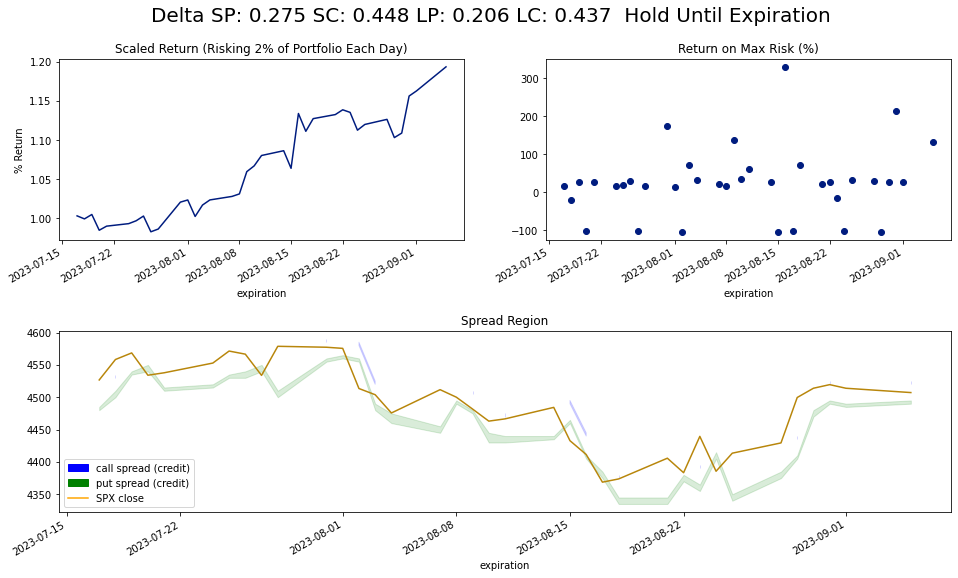

In [11]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [12]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [13]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-09-05,2023-09-06,0.275195,4485.0,0.255081,540.0,0.447567,4510.0,0.447242,535.0,0.437227,4515.0,0.340719,-390.0,0.205989,4480.0,0.203579,-390.0,4,295.0


# Strikes following the 4/2 Strategy

In [14]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-09-05,2023-09-06,0.04,4450.0,0.038972,50.0,0.02,4555.0,0.016519,10.0,2,60.0
